# Risk-Return Optimization: Implementing Markowitz Portfolio Models on Nasdaq-100
## Introduction
In the markdown we will explore a well known method of portfolio optimization - Markowitz model. This model will be later used on stocks featured in index Nasdaq-100, furthermore we will explore some variations of this method plus compare it to the Nasdaq-100 index itself and other approaches of portfolio selection.

## Data
The interesting part of this project is in the data we use. Often when doing this type of historical backtesting we would select some stock exchange as Nasdaq or an index and select all of some subset of its stocks. The main problem with this approach is the selection bias. We use stocks that are now still active while the stocks of companies that defaulted, were sold off or became irrelevant are not represented. This certainly introduces a bias that I would argue is of positive nature, inflating the hypothetical returns.

Thus, the data we used are of stocks that were listed as part of Nasdaq-100 on the December 30th 2014 (https://en.wikipedia.org/w/index.php?title=Nasdaq-100&oldid=640183946). Now this introduces additional challenge of obtaining our data as yahoo finance does not safe historical prices of delisted stocks. We were able to only partially succeed as the total number of stocks we were able to find historical data is 91. We also opted to only choose one ticker per company. The time we will be investing for is from the start of 2015 until the end of 2019. And the data we will use is from the beginning of 2010 onwards. Now the reason we decided for this period is it's relative stability and prosperity of this period. This is very beneficial for the performance Markowitz model which creates its portfolio based on historical performance of stocks and any sudden changes in behavior that are connected to economical downturns would harm the performance.

In [576]:
## Importing libraries used in the code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [229]:
## Here we have two different files which contain tickers of stocks we used. As the name suggest the first one is stocks still active and the second stocks already not present on the stock exchange
tickers_active = pd.read_csv('Nasdaq-100_active.csv', header=None, names=["Ticker"])
tickers_delisted = pd.read_csv('Nasdaq-100_delisted.csv', header=None, names=["Ticker"])
tickers = np.array(tickers_active["Ticker"].tolist() + tickers_delisted["Ticker"].tolist())
number_of_stocks = len(tickers)

In [193]:
## We download stock data (only prices which Markowitz model uses) from yahoo finance using library yfinance for active stocks. For delisted stocks we downloaded the historical data from investing.com.
stocks_prices = []
for ticker in tickers_active.Ticker:
    stock_data = yf.download(ticker, start="2010-01-01", end="2020-01-01",progress=False).Close[ticker]
    stocks_prices.append(stock_data)
    
for ticker in tickers_delisted.Ticker:
    stock_data = pd.read_csv(ticker+'.csv',index_col=0,parse_dates=['Date']).iloc[::-1].Price ## We reverse the order as we downloaded the data from newest to oldest
    stocks_prices.append(stock_data)

stocks_prices = np.array(stocks_prices,dtype=object) ## We create a numpy array we later take advantage of

In [ ]:
## Here we calculate daily returns for all the stocks up to the end of 2014.
stock_returns_before2015 = []

for stock in stocks_prices:
    mask = stock.index < '2015-01-01'
    stock_before_2015 = stock[mask]
    stock_returns = stock_before_2015.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:] ## We calculate the returns using window function, we also get the first value of the output as NaN so we just omit it
    stock_returns_before2015.append(stock_returns)

First thing good to know is if the data we collected or gathered is full for all the stocks, because later when we want to estimate the behaviour of individual stocks and their relations we need sufficient amount of data. As we clearly see in following bar chart we have only six stocks that don't possess the full history (as the last 4 in the graph have the maximum possible). For the case of CHTR there are some gaps in the data, but it's very infrequent to have a large effect on the result thus for the simplicity we will ignore this discrepancy. In all the other case these are stocks where the history starts after the start of 2010, but in our opinion we still possess enough of data to have reasonable estimates. These estimated might even be preferable as we will argue later.

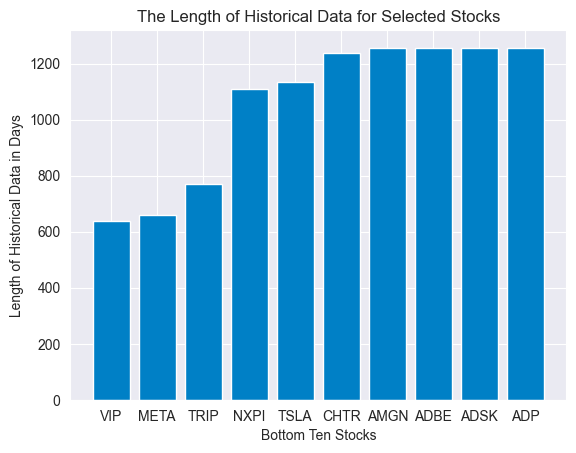

In [649]:
## Calculating the number of observations (trading days) for our stocks and ploting the result
length_of_history = []
for stock in stock_returns_before2015:
    length_of_history.append(len(stock))
length_of_history = pd.DataFrame(length_of_history,index=tickers,columns=['length'])

length_of_history = length_of_history.sort_values(by='length',ascending=True)
plt.bar(length_of_history.index[:10],length_of_history.length[:10],color='#0080C6')
plt.title('The Length of Historical Data for Selected Stocks')
plt.ylabel('Length of Historical Data in Days')
plt.xlabel('Bottom Ten Stocks')
plt.show()

Now we calculate average annual return $r$ for all the stocks from the daily average return $r_d$ using formula $r = (1 + r_d)^{251} - 1$. We use 251 as this is the standard number of trading days in a year. We will also calculate the variance of all the stocks calculated from the daily returns $x_i$ as $\frac{1}{n-1} \sum_{i=1}^n (x_i - r_d)^2$, where $n$ is the number of total trading days. We will also calculate covariance as we will use it later. The equation for the calculation is $\frac{1}{n-1} \sum_{i=1}^{n} (x_{i1} - r_{d1}) (x_{i2} - r_{d2})$, where the 1 and 2 signals if we use the returns of the first stock or the second stock in the calculation.

In [ ]:
annual_mean_returns = []

for stock_returns in stock_returns_before2015:  
    daily_mean_return = np.mean(stock_returns)
    annual_mean_return = (1+daily_mean_return)**251 - 1
    
    annual_mean_returns.append(annual_mean_return)
    
annual_mean_returns = np.array(annual_mean_returns)

covariance_matrix = np.zeros((number_of_stocks,number_of_stocks))

for i,returns_1 in enumerate(stock_returns_before2015):
    set_of_dates_1 = set(returns_1.index)
    
    for j,returns_2 in enumerate(stock_returns_before2015):
        set_of_dates_2 = set(returns_2.index)
        set_of_dates = set_of_dates_1 & set_of_dates_2 ## Here we only consider dates where both stocks had returns
        
        mask_1 = [date in set_of_dates for date in returns_1.index]
        mask_2 = [date in set_of_dates for date in returns_2.index]
        
        
        covariance_matrix[i,j] = np.cov(returns_1[mask_1],returns_2[mask_2])[0,1]

Now that we have the results we can show some interesting stocks in a plot as showing all the stocks wouldn't be very helpful as there are 91 of them. In the first plot we see the worst performing stock overall. There is not much to say about this stock, it was gradual decline of the stock value other than the sudden drop in mid 2011. But there also was high resurgence in the end of 2015 and that might be the reason the stock was part of Nasdaq-100 in 2015 (As of 2025 the stock is no longer active).

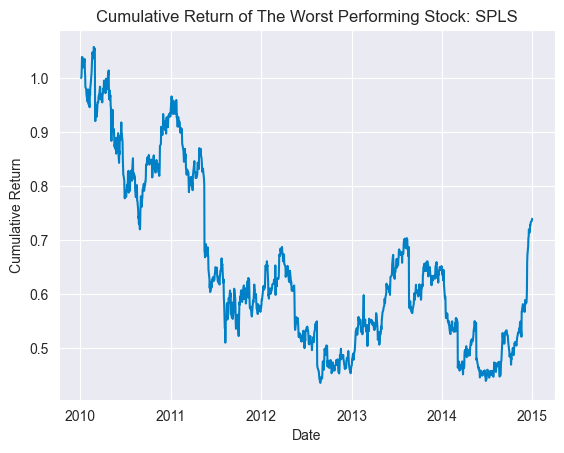

In [531]:
stocks_argsort = np.argsort(annual_mean_returns) ## Using sorting function to determine the 

plt.plot((1+stock_returns_before2015[stocks_argsort[0]]).cumprod(),color='#0080C6')
plt.title(f'Cumulative Return of The Worst Performing Stock: {tickers[stocks_argsort[0]]}')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.show()

The second plot here it the polar opposite the bets performing stock. Here we just see very steady growth over the years brining cumulative return just under 1700 percent. This stock is still part of the Nasdaq-100 index as of 2025.

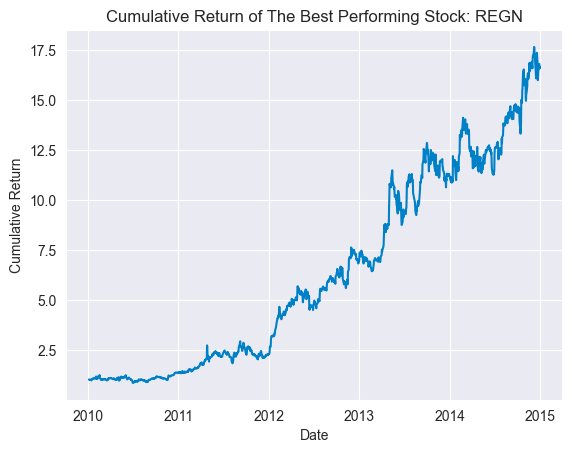

In [533]:
plt.plot((1+stock_returns_before2015[stocks_argsort[-1]]).cumprod(),color='#0080C6')
plt.title(f'Cumulative Return of The Best Performing Stock: {tickers[stocks_argsort[-1]]}')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.show()

More interesting is the following graph. Here we have stocks that at the end of the period were just in 25, 50 and 75 percentile of all the stocks. The interesting part is that each stock was at some point the best and the worst performing compared to the other two. The best of these was for the first part of the 5 years the worst of them but in mid 2012 the rise started and the stock ended with total cumulative return of 435% (which is over 40% annually). The 50 percentile one had performance of 234% (26% annually) and the worst of those three 214% (19% annually).

Now here we can clearly see a major discrepancy. As cumulative return for the 50 percentile stock is not the 1 plus annual return to the fifth power (the cumulative return would have to be 318%). But this is because of the way we calculate the annual return as the mean of the daily returns, compared to a different approach that would be to do a fifth root of the cumulative return (as 5 years passed). This might be another argument against the method we use, and we could later compare the results if we use this type of estimates of annual returns.

Bringing our attention back at the price development over the years we clearly see that all three stocks had lost part of its value at the beginning of 2014. This can be observed also for two previous stocks.

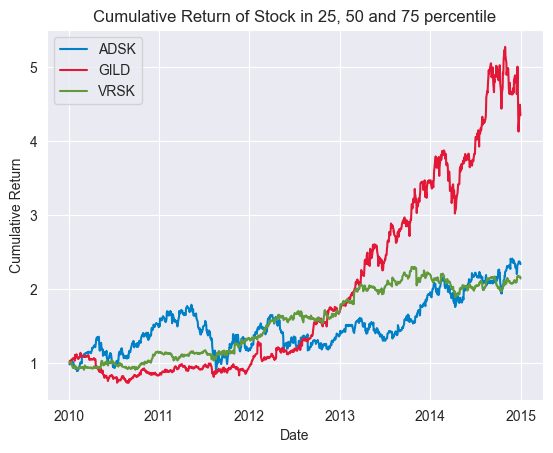

In [537]:
plt.plot((1+stock_returns_before2015[stocks_argsort[44]]).cumprod(),color='#0080C6',label=tickers[stocks_argsort[44]])
plt.plot((1+stock_returns_before2015[stocks_argsort[68]]).cumprod(),color='#E31837',label=tickers[stocks_argsort[68]])
plt.plot((1+stock_returns_before2015[stocks_argsort[23]]).cumprod(),color='#61993B',label=tickers[stocks_argsort[23]])
plt.title(f'Cumulative Return of Stock in 25, 50 and 75 percentile')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()

Now comparing all the stocks on the annual returns we calculated we can use a typical boxplot, but we also place all the stocks on top so we can clearly see more information. We clearly see that for values from 0.1 to 0.5 we have the axis heavily populated as there are many stocks that are between those values and the density seams to be rather high. We have one outlier that is around 0 and three outliers that are over 0.8. This clearly suggests that most of the stocks had extremely high returns and this signify the good condition of the economy for the whole period.

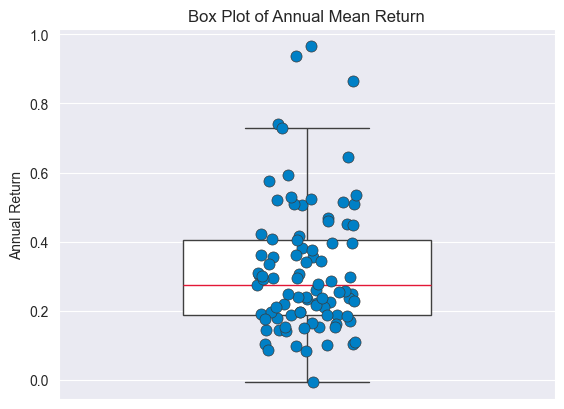

In [608]:
sns.boxplot(annual_mean_returns,boxprops={'facecolor': 'white'},medianprops={'color': '#E31837'},width=0.5,showfliers=False)
sns.stripplot(annual_mean_returns,color='#0080C6',size=8,linewidth=0.5)
plt.ylabel('Annual Return')
plt.title('Box Plot of Annual Mean Return')
plt.show()

The penultimate plot we have in the exploratory part of the project is already tightly connected to the Markowitz model as we plot the stocks respective to their annual return but also to their volatility which we calculate as a standard deviation and in the framework of Markowitz model this is the square root of the risk of the investment. The first thing we clearly observe is that certain level of risk we see that high risk means high annual return of the stock. But we fear that this might only be because of the selection bias as all these stocks are part of the Nasdaq-100 and if the stock would be highly risky but would lose most of its value as this is what we expect can happen with high risk, those stocks would probably not be part of the index. Also for the lower values of risk (those where we suppose the selection bias is not as big) we see that as the risk increases the values of the annual return is more volatile, that is to be expected as we previously hinted. 

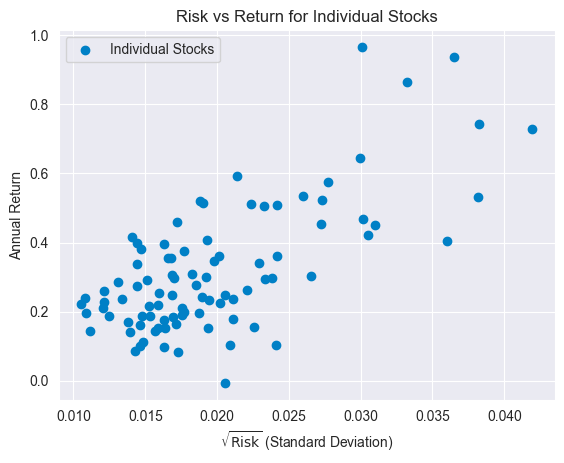

In [616]:
plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')
plt.title('Risk vs Return for Individual Stocks')
plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$ (Standard Deviation)')
plt.ylabel('Annual Return')
plt.show()

In the last plot we also want to compare these individual stocks to the index we got these stocks from Nasdaq-100. The layman guess of how the index would stack against the individual stocks could be as that we would expect it to be in the middle of both the return and the risk. And we see in plot this guess is very inaccurate as the Nasdaq-100 looks very risk-averse while having less than average return. This is very much to be expected from the expects point of view as the index is diversified product thus reducing the risk associated with volatility. The sub-average return also makes sense as some of the best performing stocks that are now (2015) part of the index were not part of it as it were very small and the stocks that were part of the index in the early days were potentially eliminated from the index, thus the composite index performed slightly worse than stocks currently part of the index.

In [ ]:
nasdaq_100_before_2015 = yf.download('^NDX', start="2010-01-01", end="2015-01-01",progress=False).Close['^NDX']
nasdaq_100_before_2015_returns = nasdaq_100_before_2015.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]
nasdaq_100_mean = ((1+np.mean(nasdaq_100_before_2015_returns))**251-1)
nasdaq_100_variance = np.var(nasdaq_100_before_2015_returns)

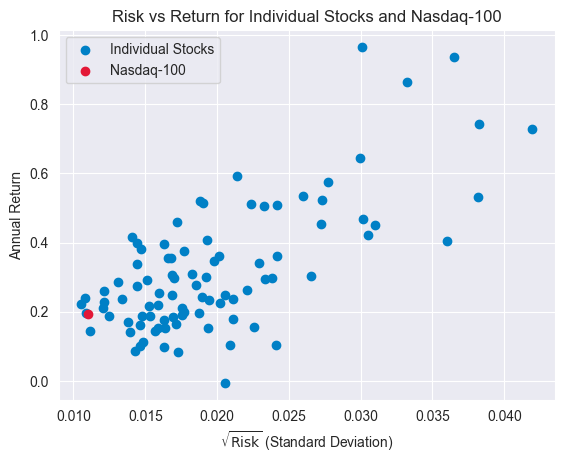

In [632]:
plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')
plt.scatter(np.sqrt(nasdaq_100_variance),nasdaq_100_mean,color='#E31837',label='Nasdaq-100')
plt.title('Risk vs Return for Individual Stocks and Nasdaq-100')
plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$ (Standard Deviation)')
plt.ylabel('Annual Return')
plt.show()

## Markowitz model

The Markowitz approach is to construct the portfolio based on two apparent but contradictory targets. We want a portfolio with as high return as possible. But on the other hand we also desire portfolio that is not risk - thus we want to minimize risk. To solve this problem of contradictory targets we select either minimal return we accept or maximal risk we wish to undergo. From this we construct two optimization problems. The first and more common is as follows

$$
\begin{align}
    \min \quad& \frac{1}{2} x^T V x \\
    \text{subject to} \quad& 1^T x = 1 \\
    & r^T x = \mu,
\end{align}
$$

where $x$ is the vector of positions we hold in different stocks, where positive value indicates long position and negative value short position. The so-called objective function which we want to minimize is half the risk of the portfolio, where $V$ is the covariance matrix. The first condition means that the sum of the weights is one as we want to invest 100% of our investment, where short positions generate additional funds at the start at no additional cost. This is unrealistic as it also ignores the spread that between buying and selling the stock, but it is commonly used in theory. The second condition inputs out desire to have an annual return of our investment as $\mu$, this annual return is expected return.

To solve this problem we will use Langrage function in the following from

$$
\begin{align}
    L(x,\delta_1,\delta_2) = \frac{1}{2} x^T V x + \delta_1 (1 - 1^T x) + \delta_2 (\mu - r^T x)
\end{align}
$$

We are going calculate the derivative of this function with respect to $x$ and set to zero and derive the solution.

$$
\begin{align}
    \frac{d}{dx} L(x,\delta_1,\delta_2) = V x - \delta_1 1 - \delta_2 r &= 0 \\
    x &= V^{-1} (\delta_1 1 + \delta_2 r)
\end{align}
$$

Using the first condition and the derived formula for $x$ we get $\delta_1$:

$$
\begin{align}
    1^T x &= 1 \\
    1^T V^{-1} (\delta_1 1 + \delta_2 r) &= 1 \\
    \delta_1 1^T V^{-1} 1 +  \delta_2 1^T V^{-1} r &= 1 \\
    \delta_1 &= \frac{1-\delta_2 1^T V^{-1} r}{1^T V^{-1} 1}
\end{align}
$$

Further we will help clarity of our equations by introducing often used notations that put $A = 1^T V^{-1} 1$, $B = 1^T V^{-1} r$, $C = r^T V^{-1} r$ and $\Delta = AC - B^2$ (keep in mind that these are all scalar numbers). Using this we have that $\delta_1 = \frac{1-\delta_2 B}{A}$. Continuing on we make use of the second condition and for formulae of $x$ and $\delta_1$ to finally derive $\delta_2$.

$$
\begin{align}
    r^T x &= \mu \\
    r^T V^{-1} (\delta_1 1 + \delta_2 r) &= \mu \\
    \delta_1 B a \delta_2 C &= \mu \\
    \frac{1-\delta_2 B}{A} B + \delta_2 C &= \mu \\
    B - \delta_2 B^2 + \delta_2 C A &= A \mu \\
    \delta_2 &= \frac{A \mu - B}{AC - B^2} \\
    \delta_2 &= \frac{A \mu - B}{\Delta}
\end{align}
$$

Now inserting this result back to the formula for $\delta_1$ we get

$$
\begin{align}
    \delta_1 &= \frac{1-\delta_2 B}{A} \\
    \delta_1 &= \frac{1-\frac{A \mu - B}{\Delta} B}{A} \\
    \delta_1 &= \frac{AC - B^2 -AB \mu + B^2}{A \Delta} \\
    \delta_1 &= \frac{C - B \mu}{\Delta}
\end{align}
$$

This is the final result we will use to calculate the Markowitz portfolio for different values of expected returns. The notation we introduced i also beneficial as we don't have to calculate it every time, but it's sufficient to calculate it once for each date and collection of stocks. We will calculate all the Markowitz portfolios for expected returns from -0.5 to 1.5.

In [617]:
inverse_covariance_matrix = np.linalg.inv(covariance_matrix) ## Inverting the covariance matrix V

## Calculating the parts of the Markowitz formula which don't change (as we change expected return)
A = np.ones(number_of_stocks).T @ inverse_covariance_matrix @ np.ones(number_of_stocks)
B = np.ones(number_of_stocks).T @ inverse_covariance_matrix @ annual_mean_returns
C = annual_mean_returns.T @ inverse_covariance_matrix @ annual_mean_returns
D = A*C - B**2

In [620]:
expected_returns = np.linspace(-0.5, 1.5, 201) ## We want mu between -0.5 and 1.5

## We calculate weights and then risk for given expected returns.
markowitz_portfolios = []

for expected_return in expected_returns:
    delta_1 = (C - B * expected_return) / D
    delta_2 = (A * expected_return - B) / D
    x = inverse_covariance_matrix @ (delta_1 * np.ones(number_of_stocks) + delta_2 * annual_mean_returns)
    ## Here we get weights but to plot the various portfolios we want to get the sqrt of risk and the expected return
    markowitz_portfolios.append((np.sqrt(x.T @ covariance_matrix @ x), x.T @ annual_mean_returns))

Not all portfolios created by Markowitz model are so-called efficient portfolios and thus part of the Efficient Frontier. Because all the results of the model creates are on some sort of parabola as we see in the following graph only one half of the parabola is the efficient frontier. What is clearly visible in the plot is that if we have correctly estimated the behaviour and the relationships of the stocks, we can create a portfolio that is much less risky while being as profitable as investing in one individual stock.

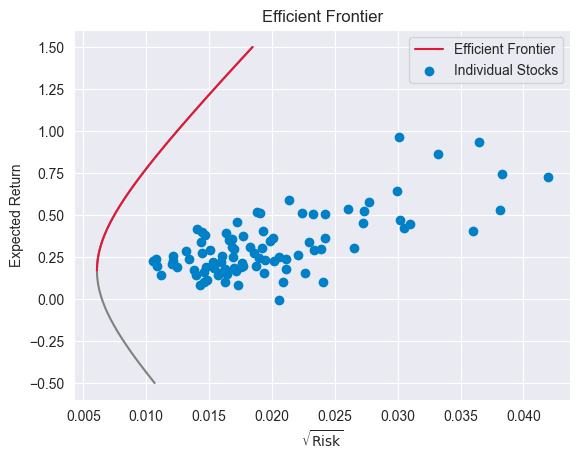

In [645]:
## Ploting the Efficient Frontier together with the individual stocks

markowitz_portfolios = pd.DataFrame(markowitz_portfolios,columns=['Risk','Return'])
plt.plot(markowitz_portfolios.Risk,markowitz_portfolios.Return,color='gray') ## Plotting all the Markowitz portfolios

efficient_frontier = markowitz_portfolios.iloc[np.argmin(markowitz_portfolios.Risk):] ## Restricting only for efficient portfolios
plt.plot(efficient_frontier.Risk,efficient_frontier.Return,color='#E31837',label='Efficient Frontier')

plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')

plt.legend()
plt.title('Efficient Frontier')
plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.show()

We can extend the possible portfolios by also considering to either not invest part of the money or invest in risk-free asset. The definition of risk-free is that there is no probability of having negative return of the investment. We will now not introduce this risk-free asset as we could argue there is none. But out code is prepared to tackle this challenge easily. Now we just say that the only safe investment is keeping the money on your bank account (or in your tresor) and set $r_0 = 0$.

This changes the set of efficient portfolios significantly as we introduce asset with no return but also no risk. We see in the previous that Markowitz portfolio with 0 return still has a significant risk. So we need significantly alter the results. We start by restating the optimization problem with $x_0$ as the portion of money we don't invest (or invest in the risk-free asset).

$$
\begin{align}
    \min \quad& \frac{1}{2} x^T V x \\
    \text{subject to} \quad& 1^T x + x_0 = 1 \\
    & r^T x + r_0 x_0 = \mu
\end{align}
$$

We can single out the $x_0$ from the first condition to put into the second condition to get the following for of the problem

$$
\begin{align}
    \min \quad& \frac{1}{2} x^T V x \\
    \text{subject to} \quad& (r - r_0 1)^T x = \mu - r_0
\end{align}
$$

This is still within the framework of Markowitz model. To solving this we again use the Langrage function.

$$
\begin{align}
    L(x,\delta) &= \frac{1}{2} x^T V x - \delta (\mu - r_0 - (r - r_0 1)^T x) \\
\end{align}
$$

$$
\begin{align}
    \frac{d}{dx} L(x,\delta) = V x + \delta (r-r_0 1) &= 0 \\
    x &= - V^{-1} \delta (r-r_0 1)
\end{align}
$$

Now we use the equivalence in the condition to get the formula for $\delta$.

$$
\begin{align}
    (r - r_0 1)^T x &= \mu - r_0 \\
    - \delta (r - r_0 1)^T V^{-1} (r-r_0 1) &= \mu - r_0 \\
    \delta &= - \frac{\mu - r_0}{(r - r_0 1)^T V^{-1} (r-r_0 1)}
\end{align}
$$

Inputting this $\delta$ back to the formula to $x$ we get

$$
\begin{align}
    x = \frac{(\mu - r_0) V^{-1} (r-r_0 1)}{(r - r_0 1)^T V^{-1} (r-r_0 1)}
\end{align}
$$

Now using the previously introduced notation we have

$$
\begin{align}
    x = \frac{(\mu - r_0) V^{-1} (r-r_0 1)}{C - 2Br_0 - A r_0^2} = \frac{(\mu - r_0) (B-Ar_0)}{C - 2Br_0 - A r_0^2} \frac{V^{-1} (r-r_0 1)}{B-Ar_0}
\end{align}
$$

where in the last equality we just multiplied the numerators and denominators by $B-Ar_0$. We did that in order to get to something which is called tangency portfolio which is the last fraction in the equation. We denote $x_T = \frac{V^{-1} (r-r_0 1)}{B-Ar_0}$. This is the only portfolio that is both the part of efficient frontier for the Markowitz model with and without risk-free asset.

Additionally, all the efficient portfolio for the model with the risk-free asset are on the line that connects tangency portfolio and portfolio where we only invest in risk_free asset. This line is known as Capital Market Line. There exist a handy formula to find a portfolio that has predetermined risk. We denote this risk as $\sigma^2$, also we need the risk of the tangency portfolio as $\sigma^T = x_T^T V x_T$ and the expected mean as $\mu_T = r^T x_T$. Portfolio with this risk has the following expected mean

$$
\begin{align}
    \mu = r_0 + \frac{\sigma}{\sigma_T} (\mu_T - r_0)
\end{align}
$$

and by inserting this into the previous formula we can get the weights.


In [198]:
## Calculating the annual risk-free interest and then tangency portfolio
risk_free_interets = 0 
tangency_portfolio_weights = (inverse_covariance_matrix @ (annual_mean_returns-risk_free_interets))/(B-risk_free_interets*A)
tangency_porfolio_mean = tangency_portfolio_weights.T @ annual_mean_returns
tangency_porfolio_variance = tangency_portfolio_weights.T @ covariance_matrix @ tangency_portfolio_weights

In [200]:
## Calculating the capital market line using formula
deviations = np.linspace(0, 0.02, 201)
capital_market_line = []
for deviation in deviations:
    mean = risk_free_interets + deviation/np.sqrt(tangency_porfolio_variance) * (tangency_porfolio_mean-risk_free_interets)
    capital_market_line.append((deviation,mean))

The plot bellow shows the capital market line. As we previously commented for each value of expected return we find a portfolio with a risk-free asset that is less risky than a any portfolio with the same return not using risk-free asset. The only exception is the tangency portfolio. But clearly the capital market line is rather close to the efficient frontier from the expected return of 0.8 onwards. What is also interesting is how high return does the tangency portfolio expect compared to any of the individual stocks. We might want to really take a look at that in our backtesting.

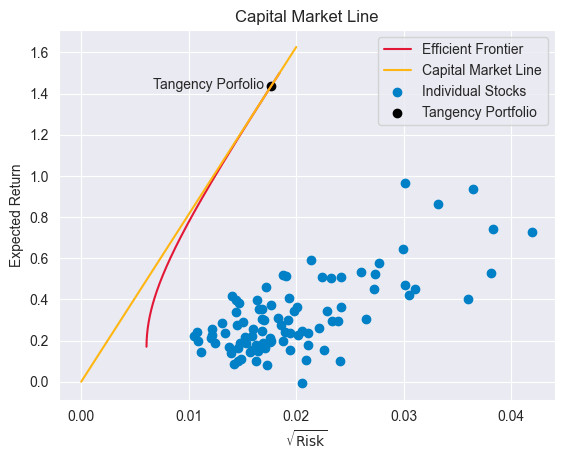

In [627]:
cml = pd.DataFrame(capital_market_line, columns=['Risk', 'Return'])

## Ploting the capital market line
plt.plot(efficient_frontier.Risk, efficient_frontier.Return, color='#E31837', label='Efficient Frontier')
plt.plot(cml.Risk, cml.Return, color='#FFB612', label='Capital Market Line')

## Ploting individual stocks
plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')

## Ploting tangency portfolio
plt.scatter(np.sqrt(tangency_porfolio_variance), tangency_porfolio_mean, color='black', label='Tangency Portfolio')
plt.annotate('Tangency Porfolio', (np.sqrt(tangency_porfolio_variance), tangency_porfolio_mean),
             textcoords="offset points", xytext=(-45, -2.5), ha='center')

plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.legend()
plt.title('Capital Market Line')
plt.show()

Turning our focus back to the case with no risk-free asset we are owing the option where we have set the maximal risk $\sigma^2$ we want to endure and want the maximum available return want. Let's formulate this optimization problem.

$$
\begin{align}
    \max \quad& r^T x \\
    \text{subject to} \quad& 1^T x = 1 \\
    & \frac{1}{2} x^T V x = \frac{\sigma^2}{2}
\end{align}
$$

The Langrange function is as follows

$$
\begin{align}
    L(x,\lambda_1,\lambda_2) = r^T x - \lambda_1 (1-1^T x) + \lambda_2 (\frac{\sigma^2}{2} - \frac{1}{2} x^T V x)
\end{align}
$$

We are going calculate the derivative of this function with respect to $x$ and set it to zero.

$$
\begin{align}
    \frac{d}{dx} L(x,\lambda_1,\lambda_2) = r + \lambda_1 1 - \lambda_2 V x &= 0 \\
    x &= V^{-1} \frac{1}{\lambda_2} (r-\lambda_1 1)
\end{align}
$$

We take the first condition and insert the formula of $x$ into it.

$$
\begin{align}
    1^T x &= 1 \\
    1^T V^{-1} \frac{1}{\lambda_2} (r-\lambda_1 1) &= 1 \\
    B - \lambda_1 A &= \lambda_2 \\
    \lambda_1 &= \frac{B-\lambda_2}{A}
\end{align}
$$

Next we use the second condition and our formulae for $x$ and $\lambda_1$.

$$
\begin{align}
    \frac{1}{2} x^T V x &= \frac{\sigma^2}{2} \\
    \frac{1}{2} (r-\lambda_1 1)^T \frac{1}{\lambda_2} V^{-1} V V^{-1} \frac{1}{\lambda_2} (r-\lambda_1 1) &= \frac{\sigma^2}{2} \\
    (r-\lambda_1 1)^T V^{-1} (r-\lambda_1 1) &= \lambda_2^2 \sigma^2 \\
    C - 2 \lambda_1 B + \lambda_1^2 A &= \lambda_2^2 \sigma^2 \\
    C - 2 \frac{B-\lambda_2}{A} B + (\frac{B-\lambda_2}{A})^2 A &= \lambda_2^2 \sigma^2 \\
    AC - 2 B^2 + 2 \lambda_2 B + B^2 - 2 \lambda_2 B + \lambda_2^2 &= \lambda_2^2 A \sigma^2 \\
    AC - B^2 &= \lambda_2^2 A \sigma^2 - \lambda_2^2 \\
    \Delta &= \lambda_2^2 (A \sigma^2 - 1) \\
    \lambda_2^2 &= \frac{\Delta}{A \sigma^2 - 1} \\
    \lambda_2 &= \pm \sqrt{\frac{\Delta}{A \sigma^2 - 1}}
\end{align}
$$

We see that we derived two possible values for $\lambda_2$ this makes sense as the shape of all possible Markowitz portfolios is a parabola. To get the one on the efficient border we select the positive $\lambda_2$. Also from the square root we see that for some values of $\sigma^2$ cannot get a result. Thus, the minimal risk portfolio is the one were $A \sigma^2 - 1 = 0$ which corresponds to $\sigma^2 = \frac{1}{A}$. This portfolio then has the expected return of $\frac{B}{A}$.

In [648]:
##tickers 
risks = np.linspace(np.min(efficient_frontier.Risk)**2, np.max(efficient_frontier.Risk)**2, 500) ## We want risk to be the same as it was for the efficient frontier where we fixed the return (to end up with the same plot).

## We calculate weights and then risk for given expected returns.
markowitz_portfolios_risk = []

for risk in risks:
    lambda_2 = np.sqrt(D/(A*risk-1))
    lambda_1 = (1/lambda_2 * B - 1)/(A/lambda_2)
    x = inverse_covariance_matrix @ (annual_mean_returns - lambda_1 * np.ones(number_of_stocks)) * (1/lambda_2)
    markowitz_portfolios_risk.append((np.sqrt(x.T @ covariance_matrix @ x), x.T @ annual_mean_returns))

The following plot is just a reassurance we constructed the same efficient frontier and we did.

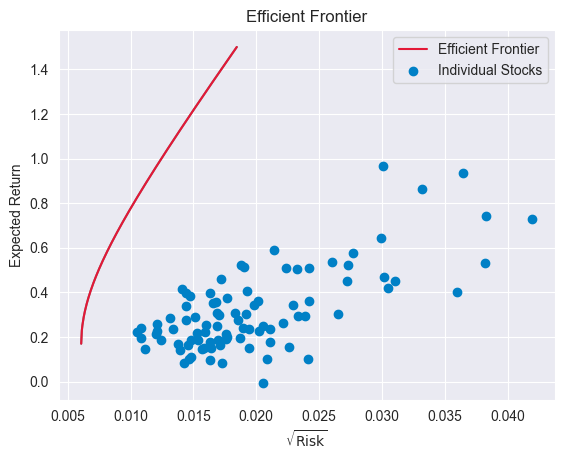

In [647]:
## Ploting the Efficient Frontier together with the individual stocks
markowitz_portfolios_risk = pd.DataFrame(markowitz_portfolios_risk, columns=['Risk', 'Return'])
plt.plot(markowitz_portfolios_risk.Risk, markowitz_portfolios_risk.Return, color='gray')

efficient_frontier_risk = markowitz_portfolios_risk.iloc[
                          np.argmin(markowitz_portfolios_risk.Risk):]  ## Restricting only for efficient portfolios
plt.plot(efficient_frontier_risk.Risk, efficient_frontier_risk.Return, color='#E31837', label='Efficient Frontier')

plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')

plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

## Backtesting

In [203]:
wanted_return = 0.25
delta_1 = A * (C - wanted_return * B) / D
delta_2 = B * (wanted_return * A - B) / D
wanted_return_weights = delta_1 * x_G + delta_2 * x_q

stocks_weights = pd.DataFrame({'Stock':tickers,'Weight':wanted_return_weights})

In [204]:
stocks_weights['Long or Short'] = np.sign(stocks_weights.Weight)
stocks_weights['Absolute Weight'] = np.abs(stocks_weights.Weight)

In [205]:
stocks_weights.sort_values(by='Absolute Weight', ascending=False, inplace=True)

<BarContainer object of 10 artists>

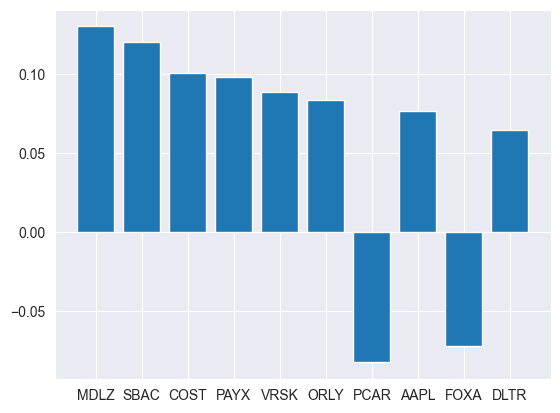

In [206]:
plt.bar(stocks_weights.Stock[:10],stocks_weights.Weight[:10])

In [339]:
stock.index[~mask]

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2014-12-17', '2014-12-18', '2014-12-19', '2014-12-22',
               '2014-12-23', '2014-12-24', '2014-12-26', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

In [340]:
stock = stocks_prices[0]
mask = stock.index >= '2014-12-31' # Returns are one shorter
dates = list(set(stock[mask].index))
dates.sort()

In [341]:
prices = pd.DataFrame(index=dates[1:]) 
returns = pd.DataFrame(index=dates[1:]) 
for i,ticker in enumerate(tickers):
    stock = stocks_prices[i]
    stock = stock.reindex(dates).ffill()
    prices[ticker] = stock
    returns[ticker] = stock.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]

In [209]:
nasdaq_100 = yf.download('^NDX', start="2015-01-01", end="2020-01-01",progress=False).Close['^NDX']
nasdaq_100 = nasdaq_100.reindex(dates).ffill()
nasdaq_100_returns = nasdaq_100.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]

In [635]:
wanted_risk = np.min(np.diag(covariance_matrix))
beta = np.sqrt((A*wanted_risk-1)/D)
alpha = (beta * B - 1)/(beta*A)

L_1,L_2 = alpha, 1/beta
wanted_risk_weights = inverse_covariance_matrix @ (annual_mean_returns - L_1 * np.ones(number_of_stocks)) * (1/L_2)

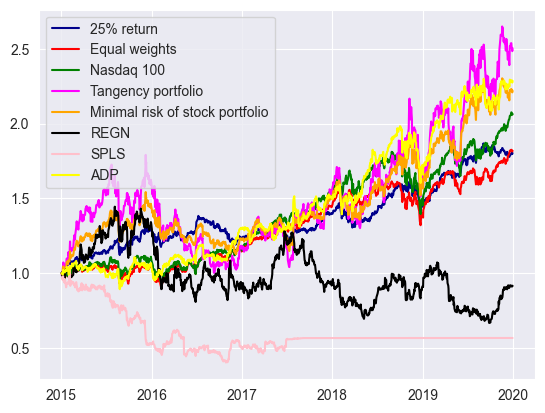

In [345]:
plt.plot((1 + returns @ wanted_return_weights).cumprod(),color='darkblue',label='25% return')
plt.plot((1 + returns @ np.ones(number_of_stocks)/number_of_stocks).cumprod(),color='red',label='Equal weights')
plt.plot((1+nasdaq_100_returns).cumprod(),color='green',label='Nasdaq 100')
plt.plot((1 + returns @ tangency_portfolio_weights).cumprod(),color='magenta',label='Tangency portfolio')
plt.plot((1 + returns @ wanted_risk_weights).cumprod(),color='orange',label='Minimal risk of stock portfolio')
plt.plot((1 + returns.REGN).cumprod(),color='black',label='REGN')
plt.plot((1 + returns.SPLS).cumprod(),color='pink',label='SPLS')
plt.plot((1 + returns.ADP).cumprod(),color='yellow',label='ADP')
plt.legend()
plt.show()

In [346]:
equal_weights = np.ones(number_of_stocks)/number_of_stocks
dict_of_returns = {
    '25% return':returns @ wanted_return_weights,
    'Equal weights' : returns @ equal_weights,
    'Nasdaq 100': nasdaq_100_returns,
    'Tangency portfolio':returns @ tangency_portfolio_weights,
    'Minimal risk of stock portfolio': returns @ wanted_risk_weights
}

In [432]:
dict_of_expected_return_and_risk = {
    '25% return':(np.sqrt(wanted_return_weights.T @ covariance_matrix @ wanted_return_weights),wanted_return_weights.T @ annual_mean_returns),
    'Equal weights' : (np.sqrt(equal_weights.T @ covariance_matrix @ equal_weights),equal_weights.T @ annual_mean_returns),
    'Nasdaq 100': (np.sqrt(nasdaq_100_variance),nasdaq_100_mean),
    'Tangency portfolio':(np.sqrt(tangency_porfolio_variance),tangency_porfolio_mean),
    'Minimal risk of stock portfolio': (np.sqrt(wanted_risk_weights.T @ covariance_matrix @ wanted_risk_weights),wanted_risk_weights.T @ annual_mean_returns)
}
portfolio_colors = {
    '25% return':'darkblue',
    'Equal weights':'red',
    'Nasdaq 100':'green',
    'Tangency portfolio':'magenta',
    'Minimal risk of stock portfolio':'orange',
    'Monthly Reweighting': 'yellow',
    'Yearly Reweighting': 'gray'
}

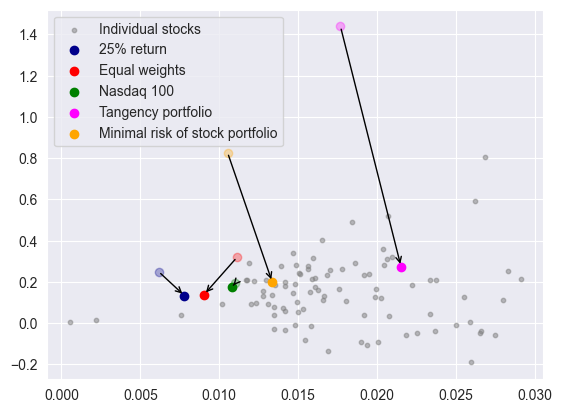

In [348]:
plt.scatter(np.std(returns, axis=0), (1 + np.mean(returns, axis=0)) ** 251 - 1, color='gray',s=10,alpha=0.5,label='Individual stocks')
for key, value in dict_of_returns.items():
    plt.scatter(np.std(value), (1+np.mean(value))**251 - 1, label=key,color=portfolio_colors[key])
    plt.scatter(dict_of_expected_return_and_risk[key][0], dict_of_expected_return_and_risk[key][1], color=portfolio_colors[key],alpha=0.3)
    plt.annotate('',xy=(np.std(value), (1+np.mean(value))**251 - 1),xytext=(dict_of_expected_return_and_risk[key][0], dict_of_expected_return_and_risk[key][1]),arrowprops=dict(arrowstyle='->',color='black'))
    
plt.legend()
plt.show()

In [220]:
reweighting_dates = [pd.Timestamp(year, month, 1) for year in range(2015, 2020) for month in range(1, 13)]

In [283]:
wanted_return = 0.25
wanted_return_monthly_weights = pd.DataFrame(wanted_return_weights,index=tickers,columns=[f'{reweighting_dates[0].year}-{reweighting_dates[0].month}'])

for date in reweighting_dates[1:]:
    active_tickers = []
    for stock_prices in stocks_prices:
        active_tickers.append(stock_prices.index.max() > date)
        
    n_act_stocks = np.sum(active_tickers)    
    
    stocks_prices_ = np.array(stocks_prices,dtype=object)[active_tickers]
    
    stocks_returns_ = []
    
    for stock in stocks_prices_:
        mask = stock.index < date
        stock_returns = stock[mask].rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]
        stocks_returns_.append(stock_returns)
    
    annual_mean_returns_ = []

    for stock_returns in stocks_returns_:  
        daily_mean_return = np.mean(stock_returns)
        annual_mean_return = (1+daily_mean_return)**251 - 1
        
        annual_mean_returns_.append(annual_mean_return)
        
    annual_mean_returns_ = np.array(annual_mean_returns_)
    
    
    covariance_matrix_ = np.zeros((n_act_stocks,n_act_stocks))
    
    for i,returns_1 in enumerate(stocks_returns_):
        set_of_dates_1 = set(returns_1.index)
        
        for j,returns_2 in enumerate(stocks_returns_):
            set_of_dates_2 = set(returns_2.index)
            set_of_dates = set_of_dates_1 & set_of_dates_2
            
            mask_1 = [date in set_of_dates for date in returns_1.index]
            mask_2 = [date in set_of_dates for date in returns_2.index]
            
            
            covariance_matrix_[i,j] = np.cov(returns_1[mask_1],returns_2[mask_2])[0,1]
    
    
    inverse_covariance_matrix_ = np.linalg.inv(covariance_matrix_) ## Inverting the matrix

    ## Calculating the parts of the Markowitz formula which don't change
    A_ = np.ones(n_act_stocks).T @ inverse_covariance_matrix_ @ np.ones(n_act_stocks)
    B_ = np.ones(n_act_stocks).T @ inverse_covariance_matrix_ @ annual_mean_returns_
    C_ = annual_mean_returns_.T @ inverse_covariance_matrix_ @ annual_mean_returns_
    D_ = A_*C_ - B_**2
    
    delta_1_ = (C_ - B_ * wanted_return) / D_
    delta_2_ = (A_ * wanted_return - B_) / D_
    x_ = inverse_covariance_matrix_ @ (delta_1_ * np.ones(n_act_stocks) + delta_2_ * annual_mean_returns_)
    
    weights_df = pd.DataFrame(x_,index=tickers[active_tickers],columns=[f'{date.year}-{date.month}'])
    
    wanted_return_monthly_weights = wanted_return_monthly_weights.join(weights_df)

In [284]:
#wanted_return_monthly_weights = wanted_return_monthly_weights.fillna(0)
#wanted_return_monthly_weights.to_csv('wanted_return_monthly_weights.csv')

In [400]:
wanted_return_monthly_weights = pd.read_csv('wanted_return_monthly_weights.csv',index_col=0)
wanted_return_monthly_weights.columns = reweighting_dates

daily_monthly_weights = wanted_return_monthly_weights.T.reindex(pd.date_range('2015-01-01', '2019-12-31', freq='D')).ffill().reindex(dates[1:])

In [394]:
wanted_return_monthly_returns = pd.DataFrame(np.diag(returns @ daily_monthly_weights.T),index=dates[1:])

In [427]:
wanted_return_yearly_weights = pd.read_csv('wanted_return_monthly_weights.csv',index_col=0)[['2015-1', '2016-1', '2017-1', '2018-1', '2019-1']]
wanted_return_yearly_weights.columns = pd.date_range('2015-01-01', '2019-12-31', freq='YS')

daily_yearly_weights = wanted_return_yearly_weights.T.reindex(pd.date_range('2015-01-01', '2019-12-31', freq='D')).ffill().reindex(dates[1:])

wanted_return_yearly_returns = pd.DataFrame(np.diag(returns @ daily_yearly_weights.T),index=dates[1:])

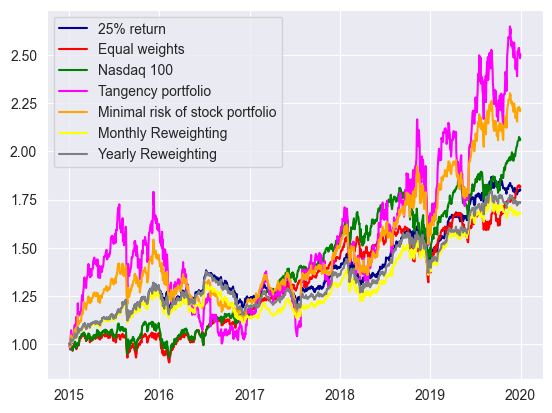

In [429]:
plt.plot((1 + returns @ wanted_return_weights).cumprod(),color='darkblue',label='25% return')
plt.plot((1 + returns @ np.ones(number_of_stocks)/number_of_stocks).cumprod(),color='red',label='Equal weights')
plt.plot((1+nasdaq_100_returns).cumprod(),color='green',label='Nasdaq 100')
plt.plot((1 + returns @ tangency_portfolio_weights).cumprod(),color='magenta',label='Tangency portfolio')
plt.plot((1 + returns @ wanted_risk_weights).cumprod(),color='orange',label='Minimal risk of stock portfolio')
plt.plot((1 + wanted_return_monthly_returns).cumprod(),color='yellow',label='Monthly Reweighting')
plt.plot((1 + wanted_return_yearly_returns).cumprod(),color='gray',label='Yearly Reweighting')
plt.legend()
plt.show()

In [430]:
equal_weights = np.ones(number_of_stocks)/number_of_stocks
dict_of_returns = {
    '25% return':returns @ wanted_return_weights,
    'Equal weights' : returns @ equal_weights,
    'Nasdaq 100': nasdaq_100_returns,
    'Tangency portfolio':returns @ tangency_portfolio_weights,
    'Minimal risk of stock portfolio': returns @ wanted_risk_weights,
    'Monthly Reweighting': wanted_return_monthly_returns,
    'Yearly Reweighting': wanted_return_yearly_returns
}

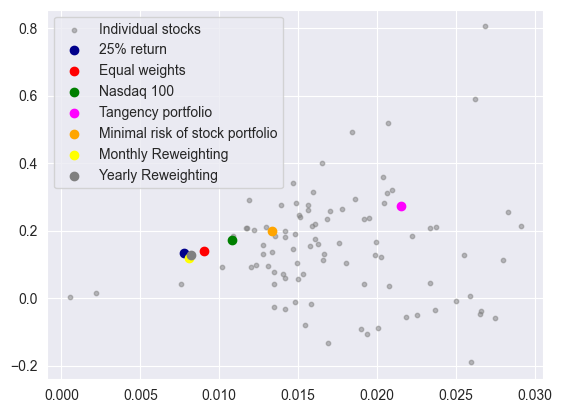

In [434]:
plt.scatter(np.std(returns, axis=0), (1 + np.mean(returns, axis=0)) ** 251 - 1, color='gray',s=10,alpha=0.5,label='Individual stocks')
for key, value in dict_of_returns.items():
    plt.scatter(np.std(value,axis=0), (1+np.mean(value))**251 - 1, label=key,color=portfolio_colors[key])
    
plt.legend()
plt.show()

## Approaches

### Aim

1.) Minimal expected return of 25%. (Both with and without risk-less asset)

2.) Maximal risk (variance) as the risk of the least risky asset

3.) Equal weights portfolio

4.) Tangency portfolio

5.) Classic Nasdaq-100

### Reweighting

1.) No

2.) Yearly

3.) Monthly